# LSTM Time Series - Stock Price Prediction
## Part 2 - Data Preprocessing
This notebook focuses on processing the filtered dataset containing the historical prices of Google stocks over the past five years.

> **INPUT**: Filtered dataset containing Google's stock prices from the last five years, obtained from the previous phase. <br/>
> **OUTPUT**: Preprocessed and transformed data divided into training, validation, and testing subsets, stored in an interim location for the training phase.

### 1. INITIALIZATION

In [1]:
# Import necessary libraries and modules
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import matplotlib.dates as mdates

In [2]:
# Set output width
pd.set_option("display.width", 120)

### 2. LOADING DATASET

In [3]:
# Prepare data file location and name
data_file_location = "../data/interim/"
data_file_name = "btc_prices_recent_updated"
data_file_ext = "csv"

# Load data file
data = pd.read_csv(data_file_location + data_file_name + "." + data_file_ext)

### 3. DATA PREPROCESSING

#### Validate Data Types

In [4]:
# Convert date column to a valid Datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Check column types
data.dtypes

Date     datetime64[ns]
Open            float64
High            float64
Low             float64
Close           float64
dtype: object

#### Select Independent Features

The objective of this analysis is to implement a multi-variant prediction, taking into account possible impact of several independent features such as the Open price, Close price and Volume on future stock price performance.

Therefore, in this analysis, we will incorporate all the available variables: 
- Opening price
- Highest price
- Lowest price
- Closing price
- Adjusted closing price
- Trading volume

These features will be utilized to forecast the future opening price.

In [6]:
# Define selected features and target attribute
features = ["Close", "Open", "High", "Low"]
target = "Close"

#### Create Train, Validation, and Test Datasets

To monitor and assess the performance of our model, we will partition the recent stock price dataset into three segments: training, validation, and testing sets.

The division will be structured as follows:
- **Training dataset:** covering the period from the start of 2019 till June, 2023.
- **Validation dataset:** representing the stock prices from July, 2023 till the end of 2023.
- **Testing dataset:** representing the stock prices for the first two months of 2024.

In [9]:
train_end_date = pd.to_datetime("2024-06-01")
validate_start_date = pd.to_datetime("2024-06-01")
validate_end_date = pd.to_datetime("2024-10-14")
test_start_date = pd.to_datetime("2024-10-15")
test_end_date = pd.to_datetime("2024-11-29")

# Split dataset into training, validation, and testing
data_train = data[data["Date"] <= train_end_date][features]
data_train_dates = data[data["Date"] <= train_end_date]["Date"]
data_validate = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)][features]
data_validate_dates = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)]["Date"]
data_test = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)][features]
data_test_dates = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]["Date"]

In [10]:
# Display the shape of each dataset
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (1614, 4)
Validation Set: (136, 4)
Testing Set: (46, 4)


In [11]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
       Close     Open     High      Low
181  67705.0  67555.0  67805.0  67171.0
182  67555.0  68635.0  68990.0  66628.0
183  68635.0  67188.0  69515.0  67112.0
184  67186.0  68368.0  68837.0  67110.0
185  68369.0  69217.0  69778.0  67235.0
Validation Dataset:
      Close     Open     High      Low
46  65930.0  62720.0  66264.0  62441.0
47  62720.0  63006.0  63354.0  62037.0
48  63006.0  63080.0  63451.0  62343.0
49  63079.0  59667.0  63402.0  59535.0
50  59666.0  60981.0  61238.0  58889.0
Testing Dataset:
     Close     Open     High      Low
0  97416.0  94825.0  98729.0  94825.0
1  94825.0  96625.0  96712.0  94688.0
2  96626.0  90981.0  97366.0  90784.0
3  90982.0  94859.0  95134.0  90755.0
4  94856.0  96884.0  98966.0  94491.0


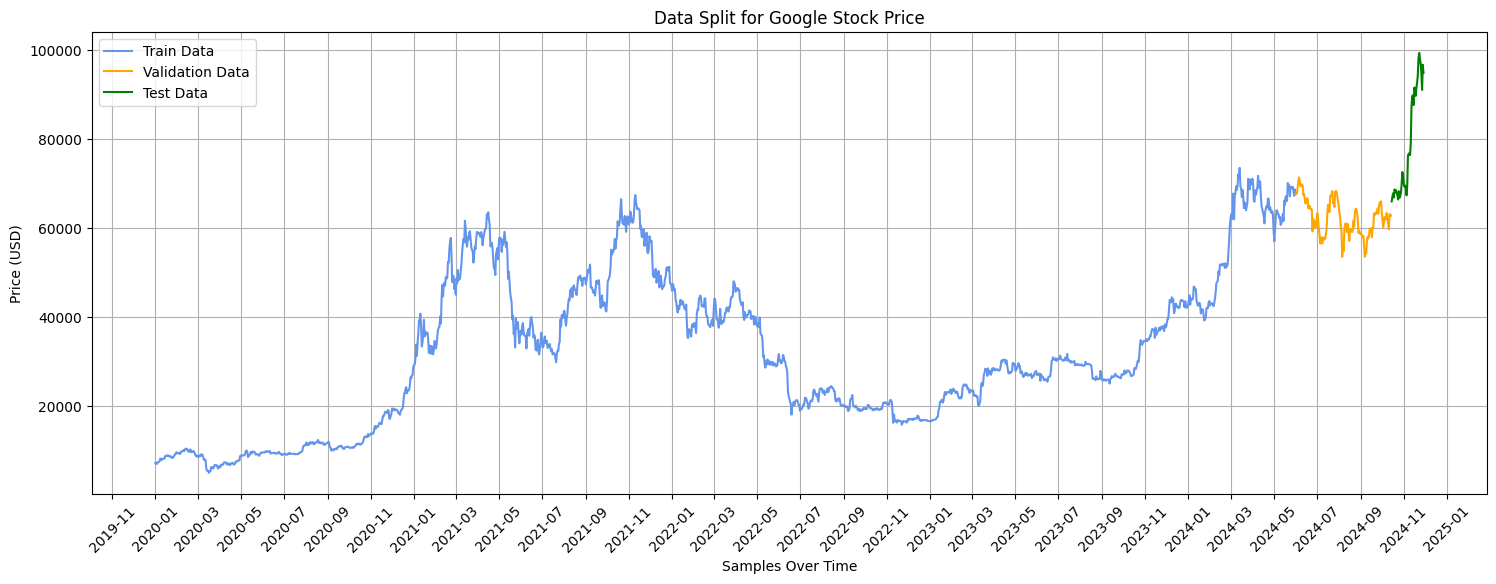

In [12]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Open"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Open"], color="orange")
plt.plot(data_test_dates, data_test["Open"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for Google Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

#### Data Scaling

In [13]:
# Check the distribution of input features
data[features].describe()

,Close,Open,High,Low
count,1795.000000,1795.000000,1795.000000,1795.000000
mean,35193.730362,35143.608914,35962.657382,34310.605571
std,19600.006072,19556.220644,20000.135095,19116.395412
min,4941.000000,4941.000000,5496.000000,3906.000000
25%,19471.500000,19469.000000,19901.500000,19080.000000
50%,31259.000000,31024.000000,31948.000000,30179.000000
75%,48970.500000,48953.000000,50443.000000,47495.000000
max,99291.000000,99292.000000,99768.000000,97256.000000


Looking at these details, it's noticeable and anticipated that all price values exhibit similar distributions given they log the price fluctuation on daily basis.

Conversely, the trading volume presents a distinct distribution that differs significantly.

Accordingly, input features need to be transformed into a unified scale and since the distribution doesn't indicate any outliers, we will use the [0,1] range to normalize all features.

To prevent data leakage, we will fit the scaler solely to the training data. Subsequently, we will use this fitted scaler to transform the training, validation, and testing datasets.

In [14]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

The scaler employed here will also be utilized in subsequent phases to revert the scaled data back to its original distribution. Therefore, it is essential to save this scaler to a local folder for future use.

In [15]:
# Prepare scaler model name and location
scaler_model_location = "../models/"
scaler_model_name = "btc_stock_price_scaler"
scaler_model_ext = "gz"

# Store scaler model
joblib.dump(sc, scaler_model_location + scaler_model_name + "." + scaler_model_ext)

['../models/btc_stock_price_scaler.gz']

### 4. STORING PROCESSED DATASETS

The training, validation, and testing datasets have been processed and are prepared for training the LSTM model in the next phase.

Prior to saving these datasets, it is necessary to reassemble the dates corresponding to each dataset. This will facilitate later evaluation of the model's performance.

In [16]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

In [17]:
# Prepare datasets files and location
data_file_location = "../data/processed/"
data_file_name_train = "btc_processed_train"
data_file_name_validate = "btc_processed_validate"
data_file_name_test = "btc_processed_test"
data_file_ext = "csv"

# Store datasets
data_train_scaled_final.to_csv(data_file_location + data_file_name_train + "." + data_file_ext, index=None)
data_validate_scaled_final.to_csv(data_file_location + data_file_name_validate + "." + data_file_ext, index=None)
data_test_scaled_final.to_csv(data_file_location + data_file_name_test + "." + data_file_ext, index=None)